In [20]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

В процессе решения пришлось неоднократно продублировать один и тот же класс stochasticprocess, с небольшими изменениями под конкретную задачу. Функции и классы работают корректно, однако есть небольшое "нагромождение кода", к сожалению найти оптимальное решение для компактности не удалось, в связи с чем предпочтение было отдано корректности работы тех или иных функций.

In [21]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [22]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

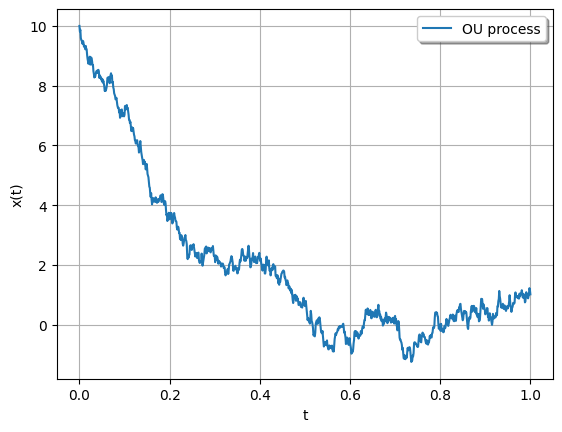

In [23]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

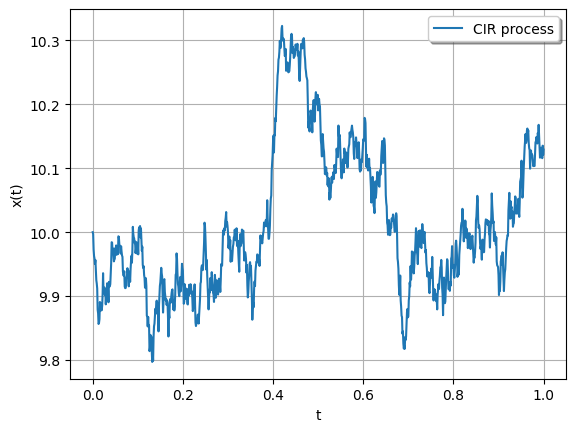

In [24]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

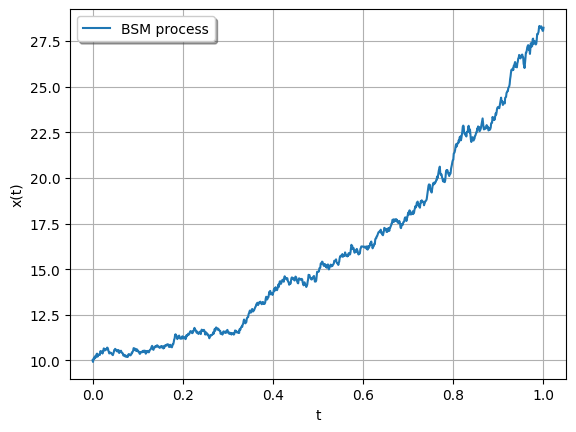

In [25]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [26]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


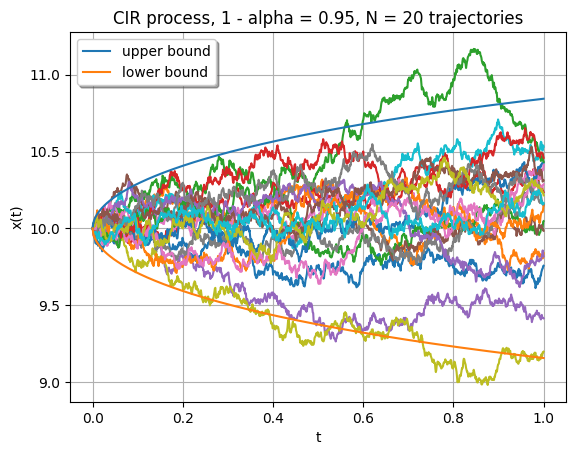

In [27]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


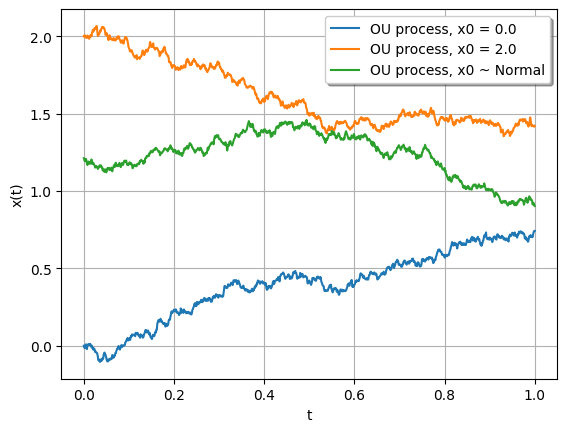

In [28]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

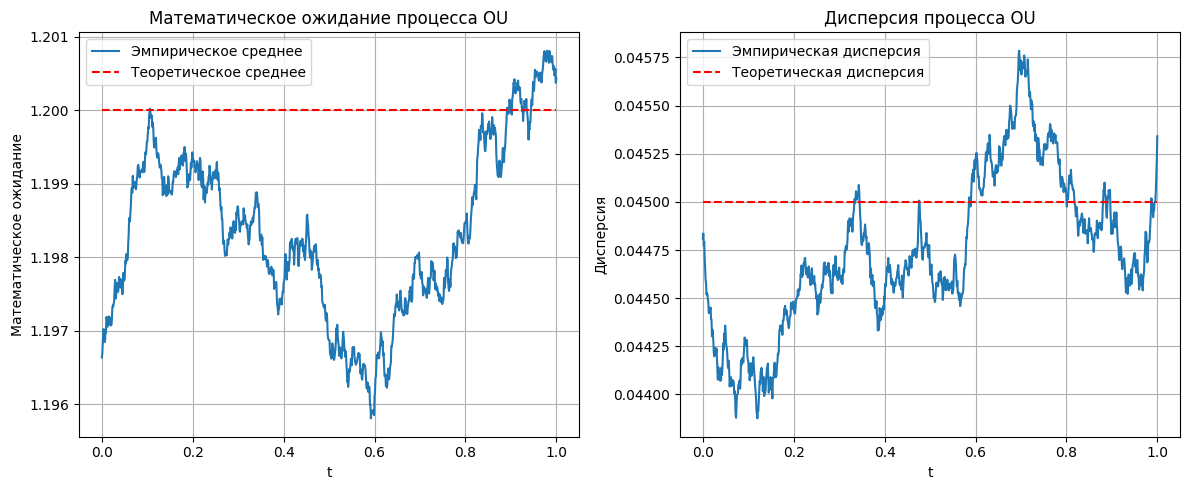

In [40]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1 # По умолчанию процессы без дрейфа и с постоянной волатильностью

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, np.sqrt(dt), size = self.Nx)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.theta = self.params[0]
        self.mu = self.params[1]
        self.sigma = self.params[2]

        self.bxt = lambda x: self.theta * (self.mu - x)
        self.sigmaxt = lambda x: self.sigma

    def sampler_init_state(self):
        return self.mu * np.ones(self.Nx)

T = 1
Nx = 10000
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

mean = mu
variance = sigma**2 / (2 * theta)
std_dev = np.sqrt(variance)
init_state = np.random.normal(mean, std_dev, size = Nx)

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()

empirical_mean = np.mean(x_data, axis=1)
empirical_variance = np.var(x_data, axis=1)
theoretical_mean = mu * np.ones_like(t_data)
theoretical_variance = variance * np.ones_like(t_data)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_data, empirical_mean, label='Эмпирическое среднее')
plt.plot(t_data, theoretical_mean, 'r--', label='Теоретическое среднее')
plt.xlabel('t')
plt.ylabel('Математическое ожидание')
plt.title('Математическое ожидание процесса OU')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t_data, empirical_variance, label='Эмпирическая дисперсия')
plt.plot(t_data, theoretical_variance, 'r--', label='Теоретическая дисперсия')
plt.xlabel('t')
plt.ylabel('Дисперсия')
plt.title('Дисперсия процесса OU')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

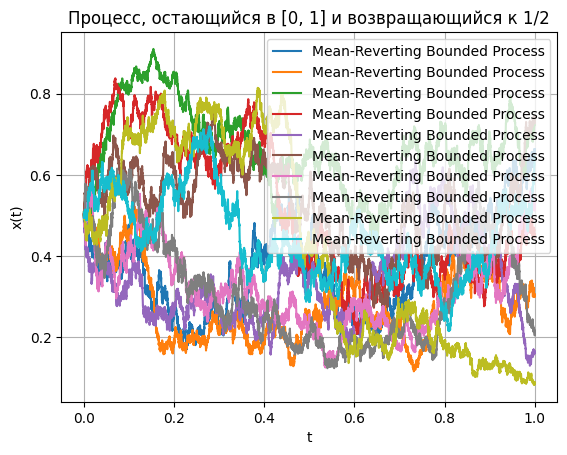

In [42]:
#модификация класса с учётом значений, выходящих за границу
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size=self.Nx) * np.sqrt(dt)
            x_prev = x_data[i - 1]
            x_new = x_prev + self.bxt(x_prev) * dt + self.sigmaxt(x_prev) * dwt
            x_new = np.clip(x_new, 0, 1)
            x_data[i] = x_new
        return t_data, x_data

class MeanRevertingBoundedProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, sigma]
        self.theta = self.params[0]
        self.sigma_param = self.params[1]
        self.bxt = lambda x: self.theta * (0.5 - x)
        self.sigmaxt = lambda x: self.sigma_param * x * (1 - x)

    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)

T = 1
Nx = 10
Nt = 10000
theta = 2.0
sigma = 2.0
params = [theta, sigma]

MRBProcess = MeanRevertingBoundedProcess(params, T, Nx, Nt)
t_data, x_data = MRBProcess.EulerSolution()

plt.plot(t_data, x_data, label='Mean-Reverting Bounded Process')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Процесс, остающийся в [0, 1] и возвращающийся к 1/2')
plt.legend()
plt.grid(True)
plt.show()


Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





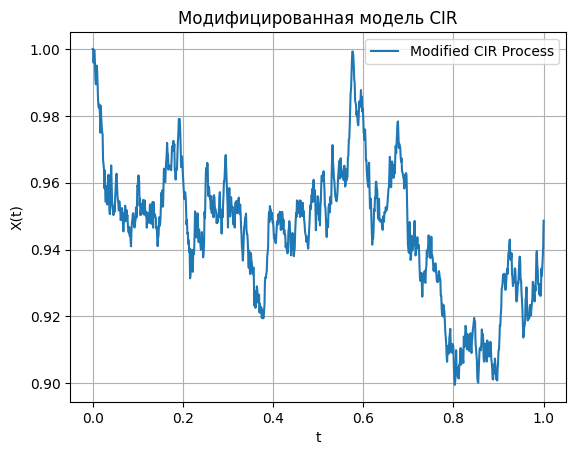

In [ ]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, theta3, gamma]
        self.theta1 = self.params[0]
        self.theta2 = self.params[1]
        self.theta3 = self.params[2]
        self.gamma = self.params[3]
        
        self.bxt = lambda x: self.theta1 * (self.theta2 - x)
        self.sigmaxt = lambda x: self.theta3 * np.power(np.maximum(x, 0), self.gamma)
    
    def sampler_init_state(self):
        return self.theta2 * np.ones(self.Nx)


T = 1
Nx = 1
Nt = 1000
theta1 = 0.5
theta2 = 1.0
theta3 = 0.1
gamma = 0.75
params = [theta1, theta2, theta3, gamma]

init_state = theta2 * np.ones(Nx)
modCIRProcess = ModifiedCIRProcess(params, T, Nx, Nt, init_state)
t_data, x_data = modCIRProcess.EulerSolution()

plt.plot(t_data, x_data, label='Modified CIR Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Модифицированная модель CIR')
plt.legend()
plt.grid(True)
plt.show()


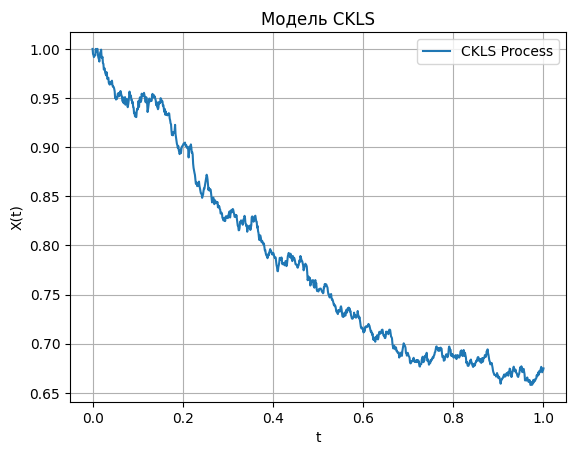

In [ ]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [alpha, beta, sigma, gamma]
        self.alpha = self.params[0]
        self.beta = self.params[1]
        self.sigma_param = self.params[2]
        self.gamma = self.params[3]
        
        self.bxt = lambda x: self.alpha + self.beta * x
        self.sigmaxt = lambda x: self.sigma_param * np.power(np.maximum(x, 0), self.gamma)
    
    def sampler_init_state(self):
        return np.ones(self.Nx)

T = 1
Nx = 1
Nt = 1000
alpha = 0.02
beta = -0.5
sigma = 0.1
gamma = 1.0  #если 0.5, то будет CIR
params = [alpha, beta, sigma, gamma]

init_state = np.ones(Nx)
cklsProcess = CKLSProcess(params, T, Nx, Nt, init_state)
t_data, x_data = cklsProcess.EulerSolution()

plt.plot(t_data, x_data, label='CKLS Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Модель CKLS')
plt.legend()
plt.grid(True)
plt.show()


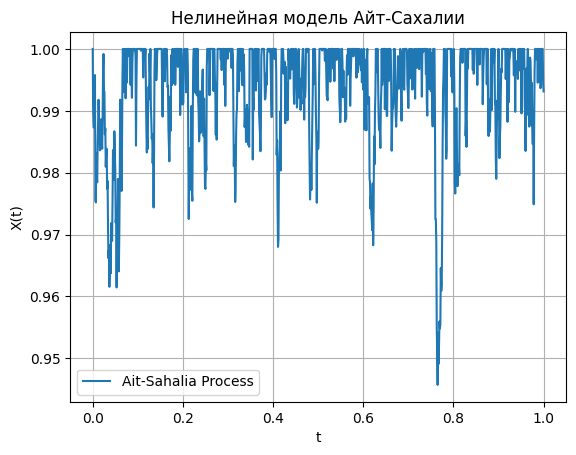

In [ ]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [alpha, beta, gamma, delta, sigma, theta]
        self.alpha = self.params[0]
        self.beta = self.params[1]
        self.gamma = self.params[2]
        self.delta = self.params[3]
        self.sigma_param = self.params[4]
        self.theta = self.params[5]
        
        self.bxt = lambda x: self.alpha * np.power(np.maximum(x, 0), self.beta) - \
                             self.gamma * np.power(np.maximum(x, 0), self.delta)
        self.sigmaxt = lambda x: self.sigma_param * np.power(np.maximum(x, 0), self.theta)
    
    def sampler_init_state(self):
        return np.ones(self.Nx)

T = 1
Nx = 1
Nt = 1000
alpha = 5.0
beta = 0.5
gamma = 3.0
delta = 1.0
sigma = 0.2
theta = 0.5
params = [alpha, beta, gamma, delta, sigma, theta]

init_state = np.ones(Nx)
aitSahaliaProcess = AitSahaliaProcess(params, T, Nx, Nt, init_state)
t_data, x_data = aitSahaliaProcess.EulerSolution()

plt.plot(t_data, x_data, label='Ait-Sahalia Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Нелинейная модель Айт-Сахалии')
plt.legend()
plt.grid(True)
plt.show()


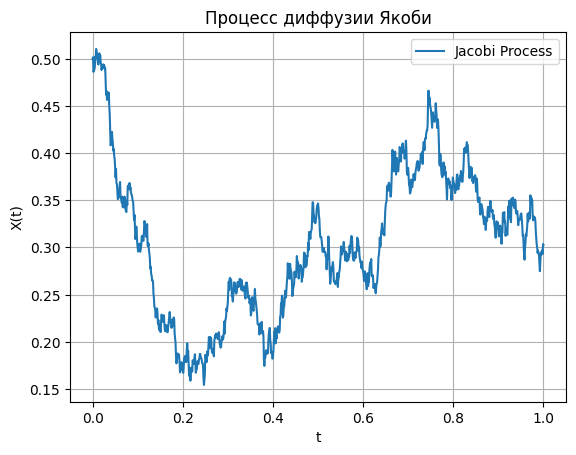

In [ ]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [kappa, theta, sigma]
        self.kappa = self.params[0]
        self.theta = self.params[1]
        self.sigma_param = self.params[2]
        
        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma_param * np.sqrt(np.maximum(x * (1 - x), 0))
    
    def sampler_init_state(self):
        return self.theta * np.ones(self.Nx)
    
T = 1
Nx = 1
Nt = 1000
kappa = 2.0
theta = 0.5
sigma = 0.5
params = [kappa, theta, sigma]

init_state = theta * np.ones(Nx)
jacobiProcess = JacobiProcess(params, T, Nx, Nt, init_state)
t_data, x_data = jacobiProcess.EulerSolution()

plt.plot(t_data, x_data, label='Jacobi Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Процесс диффузии Якоби')
plt.legend()
plt.grid(True)
plt.show()



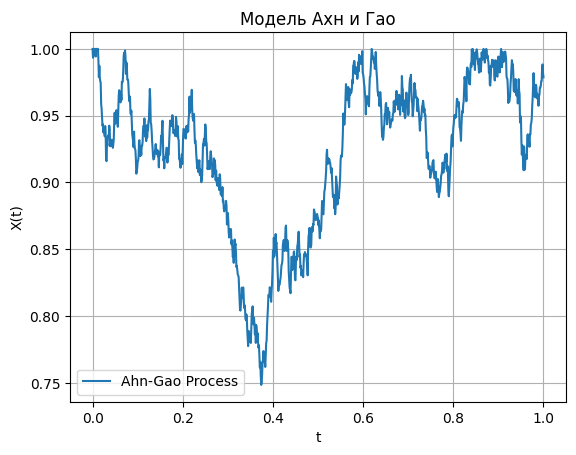

In [ ]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, theta3]
        self.theta1 = self.params[0]
        self.theta2 = self.params[1]
        self.theta3 = self.params[2]
        
        self.bxt = lambda x: self.theta1 + self.theta2 * x
        self.sigmaxt = lambda x: self.theta3 / np.sqrt(np.maximum(x, 1e-6))
    
    def sampler_init_state(self):
        return np.ones(self.Nx)

T = 1
Nx = 1
Nt = 1000
theta1 = 0.05
theta2 = -0.1
theta3 = 0.2
params = [theta1, theta2, theta3]

init_state = np.ones(Nx)
ahnGaoProcess = AhnGaoProcess(params, T, Nx, Nt, init_state)
t_data, x_data = ahnGaoProcess.EulerSolution()

plt.plot(t_data, x_data, label='Ahn-Gao Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Модель Ахн и Гао')
plt.legend()
plt.grid(True)
plt.show()


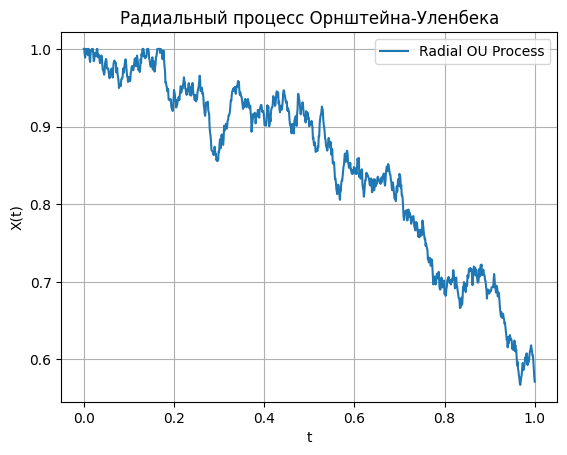

In [ ]:
class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, lambda, sigma, n]
        self.theta = self.params[0]
        self.lambda_param = self.params[1]
        self.sigma_param = self.params[2]
        self.n = self.params[3]
        
        self.bxt = lambda x: self.theta - self.lambda_param * x - \
                             ((self.n - 1) * self.sigma_param ** 2) / (2 * np.maximum(x, 1e-6))
        self.sigmaxt = lambda x: self.sigma_param
    
    def sampler_init_state(self):
        return np.ones(self.Nx)

T = 1
Nx = 1
Nt = 1000
theta = 0.0
lambda_param = 0.5
sigma = 0.2
n = 3  # желаемая размерность (исользовал 3 в качестве примера)
params = [theta, lambda_param, sigma, n]

init_state = np.ones(Nx)
radialOUProcess = RadialOUProcess(params, T, Nx, Nt, init_state)
t_data, x_data = radialOUProcess.EulerSolution()

plt.plot(t_data, x_data, label='Radial OU Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Радиальный процесс Орнштейна-Уленбека')
plt.legend()
plt.grid(True)
plt.show()


Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

Время t = 1.00
Эмпирическое математическое ожидание: 0.4654
Теоретическое математическое ожидание: 0.4684
Эмпирический второй момент: 0.4251
Теоретический второй момент: 1.6005


C:\Users\smart\AppData\Local\Temp\ipykernel_8684\1906261749.py:86: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  combinatorial = np.math.factorial(n) / (np.math.factorial(n - 2 * j) * np.math.factorial(j) * 2 ** j)


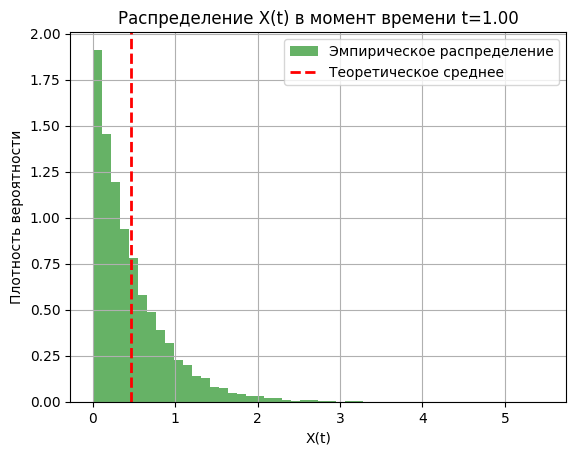

In [ ]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size=self.Nx) * np.sqrt(dt)
            x_prev = x_data[i - 1]
            x_new = x_prev + self.bxt(x_prev) * dt + self.sigmaxt(x_prev) * dwt
            x_new = np.maximum(x_new, 0)
            x_data[i] = x_new
        return t_data, x_data

class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [kappa, theta, sigma]
        self.kappa = self.params[0]
        self.theta = self.params[1]
        self.sigma = self.params[2]

        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.theta * np.ones(self.Nx)

    def ExactSolution(self, t_data):
        X0 = self.init_state[0]
        kappa = self.kappa
        theta = self.theta
        sigma = self.sigma

        exp_neg_kappa_t = np.exp(-kappa * t_data)
        A_t = exp_neg_kappa_t * X0 + theta * (1 - exp_neg_kappa_t)
        B_t = sigma * exp_neg_kappa_t
        return A_t, B_t

    def TheoreticalMoment(self, n, t):
        kappa = self.kappa
        theta = self.theta
        sigma = self.sigma
        X0 = self.init_state[0]

        exp_neg_kappa_t = np.exp(-kappa * t)
        exp_2kappa_t = np.exp(2 * kappa * t)
        A_t = exp_neg_kappa_t * X0 + theta * (1 - exp_neg_kappa_t)
        B_t = sigma * exp_neg_kappa_t
        S_t = (1 / (2 * kappa)) * (exp_2kappa_t - 1)

        moment = 0
        n_half = n // 2
        for j in range(n_half + 1):
            coeff = A_t ** (n - 2 * j) * B_t ** (2 * j) * S_t ** (2 * j)
            combinatorial = np.math.factorial(n) / (np.math.factorial(n - 2 * j) * np.math.factorial(j) * 2 ** j)
            moment += combinatorial * coeff
        return moment

T = 1.0
Nx = 10000
Nt = 1000

kappa = 1.0
theta = 0.45
sigma = 1.0
params = [kappa, theta, sigma]

X0 = 0.5
init_state = X0 * np.ones(Nx)
CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
t_index = Nt
t = t_data[t_index]
X_t = x_data[t_index]

empirical_mean = np.mean(X_t)
empirical_second_moment = np.mean(X_t ** 2)

theoretical_mean = CIRProcess.TheoreticalMoment(1, t)
theoretical_second_moment = CIRProcess.TheoreticalMoment(2, t)

print(f"Время t = {t:.2f}")
print(f"Эмпирическое математическое ожидание: {empirical_mean:.4f}")
print(f"Теоретическое математическое ожидание: {theoretical_mean:.4f}")
print(f"Эмпирический второй момент: {empirical_second_moment:.4f}")
print(f"Теоретический второй момент: {theoretical_second_moment:.4f}")

plt.hist(X_t, bins=50, density=True, alpha=0.6, color='g', label='Эмпирическое распределение')
plt.axvline(theoretical_mean, color='r', linestyle='dashed', linewidth=2, label='Теоретическое среднее')
plt.xlabel('X(t)')
plt.ylabel('Плотность вероятности')
plt.title(f'Распределение X(t) в момент времени t={t:.2f}')
plt.legend()
plt.grid(True)
plt.show()


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.



Время полураспада h = 1.39


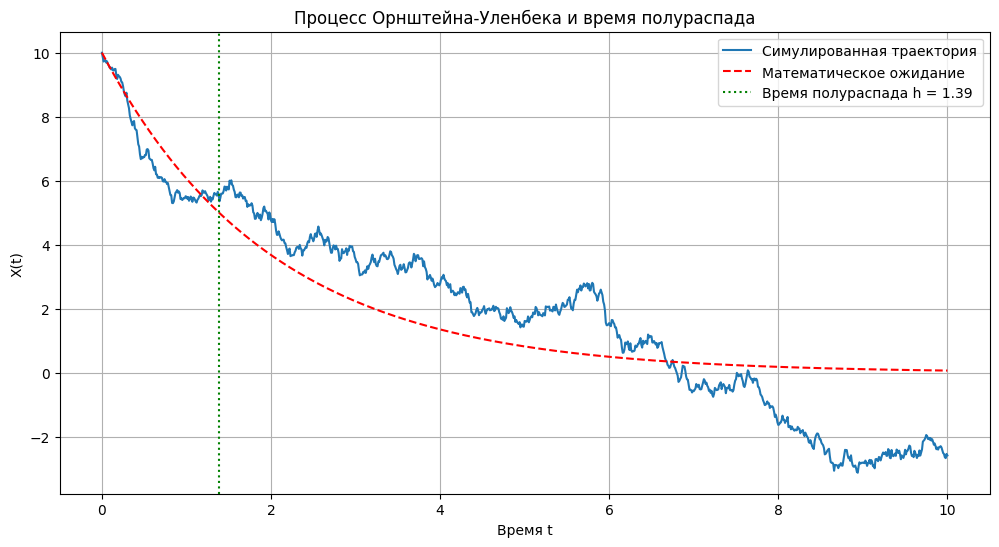

In [ ]:
theta = 0.5  
sigma = 1.0 
x0 = 10.0   

T = 10 
Nt = 1000   
dt = T / Nt
t_data = np.linspace(0, T, Nt + 1)

def simulate_ou_process(theta, sigma, x0, T, Nt):
    dt = T / Nt
    t_data = np.linspace(0, T, Nt + 1)
    x_data = np.zeros(Nt + 1)
    x_data[0] = x0

    for i in range(1, Nt + 1):
        dw = np.random.normal(0, np.sqrt(dt))
        x_data[i] = x_data[i - 1] - theta * x_data[i - 1] * dt + sigma * dw

    return t_data, x_data

t_data, x_data = simulate_ou_process(theta, sigma, x0, T, Nt)

h = np.log(2) / theta
print(f"Время полураспада h = {h:.2f}")

expected_x = x0 * np.exp(-theta * t_data)

plt.figure(figsize=(12, 6))
plt.plot(t_data, x_data, label='Симулированная траектория')
plt.plot(t_data, expected_x, 'r--', label='Математическое ожидание')
plt.axvline(h, color='g', linestyle=':', label=f'Время полураспада h = {h:.2f}')
plt.xlabel('Время t')
plt.ylabel('X(t)')
plt.title('Процесс Орнштейна-Уленбека и время полураспада')
plt.legend()
plt.grid(True)
plt.show()
